In [1]:
## Train a model to classify the images
#
## Import libraries

import os
import numpy as np

from tensorflow import keras
np.random.seed(0)

import src.config as config
from src.dataloader import read_train, read_val
from src.preprocessing import CustomDataGenerator
from src.results import plot_history, plot_cm, class_report,\
                            save_params, write_summary
from src.utils import setup_logger, header
import argparse
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


RAW_DATA_PATH = 'input/data/raw'
META_PATH = 'input/metadata/'

## Set up constants
LEARNING_RATE = .0001
BATCH_SIZE = 64
EPOCHS = 15
EXPNAME = "experiment"
EVENTNAME = f"lr_{LEARNING_RATE}_bs_{BATCH_SIZE}_ep_{EPOCHS}"
OUTPUT_FOLDER = "notebooks/experiments/augmentation_3conv_3dense/output"


#Readind data directly from the csv file and raw images in order to use data augmentation
df_labels = pd.read_csv(os.path.join(META_PATH, 'MAMe_labels.csv'), header=None, names=['id', 'label'])
df_labels['label'] = df_labels['label'].str.strip()
df_info = pd.read_csv(META_PATH + 'MAMe_dataset.csv')
df_info["Medium"] = df_info["Medium"].str.strip()
df_load_data = df_info.merge(df_labels, right_on='label', left_on='Medium')[['Image file', 'Subset', 'Medium']]

df_load_data

2023-11-05 14:08:32.866016: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 14:08:32.888423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 14:08:33.225243: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,Image file,Subset,Medium
0,436018.jpg,train,Oil on canvas
1,11779.jpg,train,Oil on canvas
2,19022.jpg,train,Oil on canvas
3,435883.jpg,train,Oil on canvas
4,10481.jpg,train,Oil on canvas
...,...,...,...
37402,261318.jpg,test,Albumen photograph
37403,646703.jpg,test,Albumen photograph
37404,417445.jpg,test,Albumen photograph
37405,646328.jpg,test,Albumen photograph


In [2]:

datagen = ImageDataGenerator(
                                rotation_range=30,        # Random rotation between -30 and 30 degrees
                                width_shift_range=0.125,    # Random horizontal shifting (crop)
                                height_shift_range=0.125,   # Random vertical shifting (crop)
                                horizontal_flip=True,     # Randomly flip images horizontally
                                rescale=1./255.,          # Rescale pixel values to the range [0, 1]
                                # featurewise_center=True,  # Normalize by subtracting mean pixel value
                                # featurewise_std_normalization=True,  # Normalize by dividing by standard deviation

)

val_datagen = ImageDataGenerator(rescale=1./255.,
                                # preprocessing_function=lambda x: center_crop(x, 200, 200),
                                # featurewise_center=True,  # Normalize by subtracting mean pixel value
                                # featurewise_std_normalization=True,  # Normalize by dividing by standard deviation
)
# val_datagen.mean = 0.5
# val_datagen.std = 0.5

# val_datagen.mean = 0.5795
# val_datagen.std = 4.22
# df_load_data['id'] = df_load_data['id'].astype('str') # requires target in string format

train_generator_df = datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'train'], 
                                              directory=RAW_DATA_PATH,
                                              x_col="Image file", 
                                              y_col="Medium", 
                                              class_mode="sparse", 
                                              target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                              batch_size=BATCH_SIZE,
                                              seed=2020)

val_generator_df = val_datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'val'], 
                                              directory=RAW_DATA_PATH,
                                              x_col="Image file", 
                                              y_col="Medium", 
                                              class_mode="sparse", 
                                              target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                              batch_size=BATCH_SIZE,
                                              seed=2020)


test_generator_df = val_datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'val'],
                                                    directory=RAW_DATA_PATH,
                                                    x_col="Image file", 
                                                    y_col="Medium",
                                                    class_mode="sparse",
                                                    target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=2020)

y_val = val_generator_df.classes
labels = list(train_generator_df.class_indices.keys())

## Define architecture
layers = [
        
        keras.Input(shape=(config.IMG_SIZE, config.IMG_SIZE, config.N_CHANNELS)),
        keras.layers.Conv2D(16,(3,3), activation = 'relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size = (4, 4)),
        keras.layers.Conv2D(32,(3,3), activation = 'relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size = (4, 4)),
        keras.layers.Conv2D(64,(3,3), activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size = (4, 4)),

        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(29, activation='softmax')
]

model = keras.Sequential(layers)

model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Found 20300 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.


2023-11-05 14:08:34.173713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 14:08:34.189860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 14:08:34.189989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
## Train model
history = model.fit(train_generator_df,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=val_generator_df)

Epoch 1/15


2023-11-05 14:08:38.583340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-05 14:08:38.635288: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-11-05 14:08:38.635303: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-11-05 14:08:38.635338: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-05 14:08:38.814902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


318/318 [==============================] - 106s 328ms/step - loss: 2.8161 - accuracy: 0.2201 - val_loss: 2.9652 - val_accuracy: 0.1510
Epoch 2/15
318/318 [==============================] - 105s 332ms/step - loss: 2.1463 - accuracy: 0.3660 - val_loss: 2.0158 - val_accuracy: 0.4000
Epoch 3/15
318/318 [==============================] - 106s 332ms/step - loss: 1.9061 - accuracy: 0.4283 - val_loss: 1.8641 - val_accuracy: 0.4428
Epoch 4/15
318/318 [==============================] - 105s 331ms/step - loss: 1.7736 - accuracy: 0.4609 - val_loss: 1.7497 - val_accuracy: 0.4828
Epoch 5/15
318/318 [==============================] - 105s 331ms/step - loss: 1.6750 - accuracy: 0.4916 - val_loss: 1.7669 - val_accuracy: 0.4648
Epoch 6/15
318/318 [==============================] - 106s 332ms/step - loss: 1.5895 - accuracy: 0.5140 - val_loss: 1.6840 - val_accuracy: 0.4903
Epoch 7/15
318/318 [==============================] - 106s 332ms/step - loss: 1.5268 - accuracy: 0.5332 - val_loss: 1.5994 - val_accura

In [4]:
model.evaluate(test_generator_df)

23/23 [==============================] - 1s 57ms/step - loss: 1.5373 - accuracy: 0.5393


[1.5373215675354004, 0.5393103361129761]

23/23 [==============================] - 1s 57ms/step


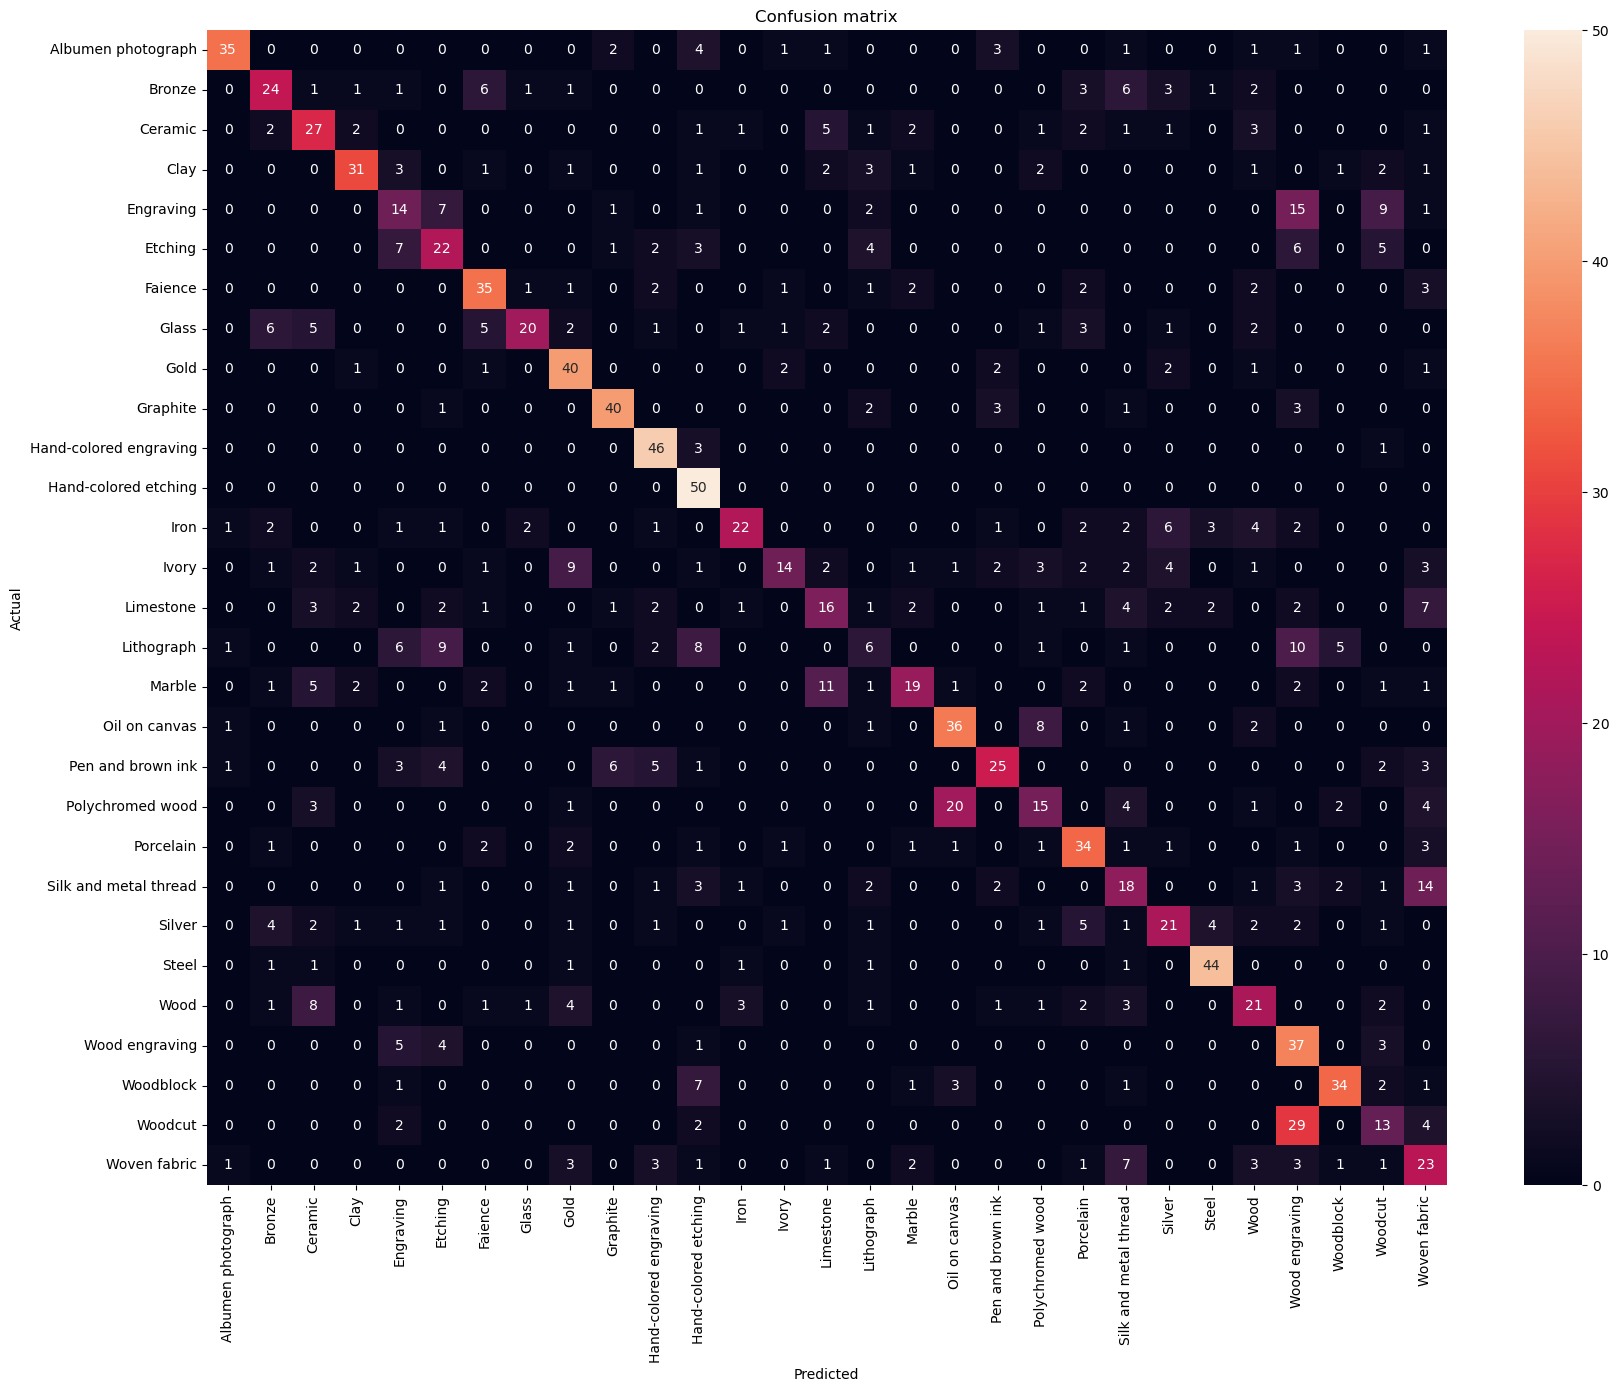

In [10]:
from src.results import plot_history, plot_cm, class_report

y_pred = model.predict(test_generator_df)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_generator_df.labels

plot_cm(y_true, y_pred, df_labels.label.unique())
plt.savefig(os.path.join(OUTPUT_FOLDER, 'confusion_matrix.png'));

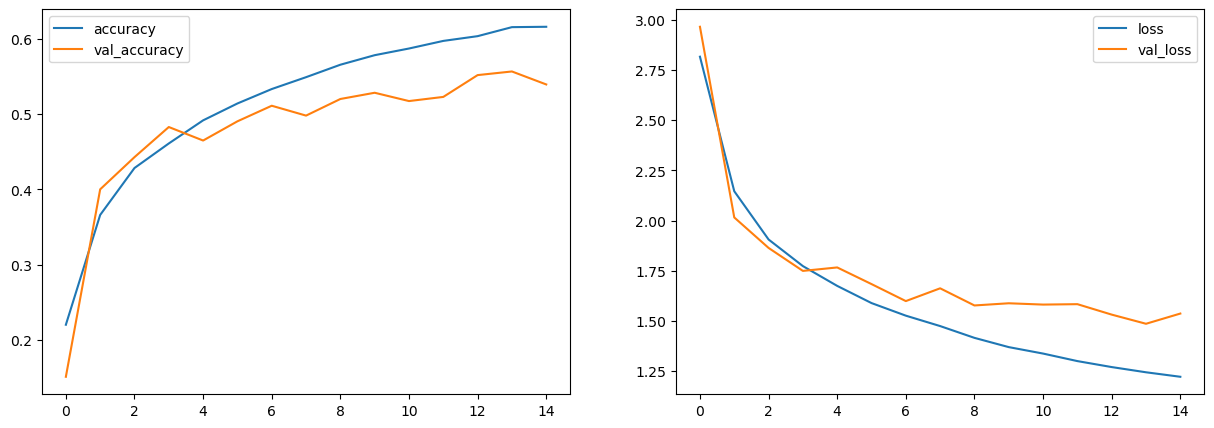

In [9]:
df_hist = history.history
df_hist = pd.DataFrame(df_hist)

fig, ax = plt.subplots(1,2, figsize=(15,5))
df_hist[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df_hist[['loss', 'val_loss']].plot(ax=ax[1])
fig.savefig(os.path.join(OUTPUT_FOLDER, f"{EXPNAME}_{EVENTNAME}_history.png"))

In [8]:
model.save(os.path.join(OUTPUT_FOLDER, 'model.h5'))


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
## Train model
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE/10),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_2 = model.fit(train_generator_df,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=val_generator_df)

Epoch 1/15
318/318 [==============================] - 106s 334ms/step - loss: 1.1499 - accuracy: 0.6422 - val_loss: 1.4341 - val_accuracy: 0.5628
Epoch 2/15
318/318 [==============================] - 106s 334ms/step - loss: 1.1399 - accuracy: 0.6462 - val_loss: 1.4398 - val_accuracy: 0.5621
Epoch 3/15
318/318 [==============================] - 106s 333ms/step - loss: 1.1298 - accuracy: 0.6456 - val_loss: 1.4152 - val_accuracy: 0.5662
Epoch 4/15
318/318 [==============================] - 106s 332ms/step - loss: 1.1292 - accuracy: 0.6467 - val_loss: 1.4084 - val_accuracy: 0.5662
Epoch 5/15
318/318 [==============================] - 106s 332ms/step - loss: 1.1244 - accuracy: 0.6491 - val_loss: 1.4523 - val_accuracy: 0.5628
Epoch 6/15
318/318 [==============================] - 106s 332ms/step - loss: 1.1291 - accuracy: 0.6471 - val_loss: 1.4197 - val_accuracy: 0.5710
Epoch 7/15
318/318 [==============================] - 105s 331ms/step - loss: 1.1205 - accuracy: 0.6556 - val_loss: 1.4273 -

<Axes: >

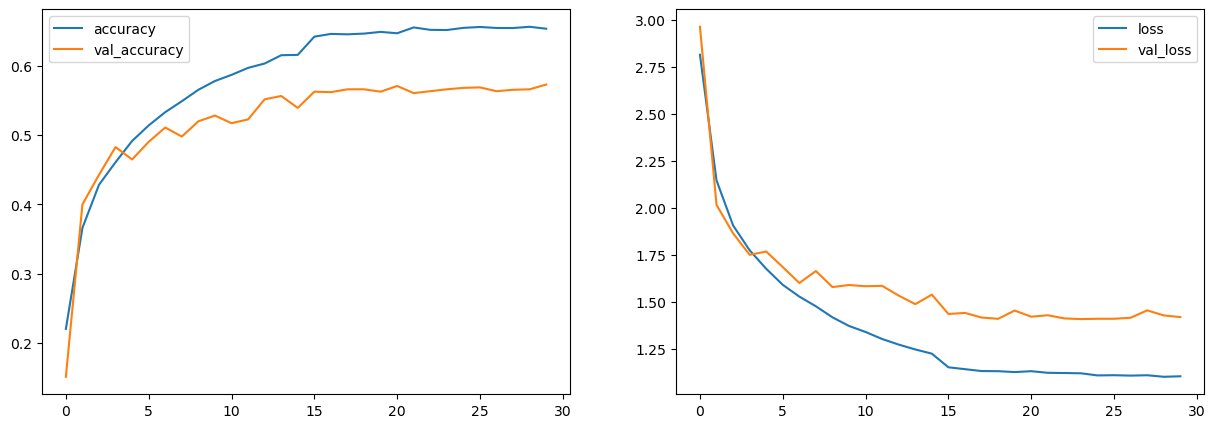

In [15]:
df_hist_2 = history_2.history
df_hist_2 = pd.DataFrame(df_hist_2)

df_hist_total = pd.concat([df_hist, df_hist_2], axis=0, ignore_index=True)
fig, ax = plt.subplots(1,2, figsize=(15,5))
df_hist_total[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df_hist_total[['loss', 'val_loss']].plot(ax=ax[1])